In [1]:
library(fmsb)

In [2]:
parseCurrency = function(item) {
    if (length(grep('달러', item))) {
        item = as.numeric(substr(item, 1, nchar(item)-2)) * 1130
    } else if (length(grep('만원', item))) {
        item = as.numeric(substr(item, 1, nchar(item)-2)) * 10000
    } else {
        item = as.numeric(item)
    }
    return(item)
}

In [3]:
parseAge = function(item) {
    return(2015 - as.numeric(substr(item, 1, 4)))
}

In [4]:
parseHeight = function(item) {
    height = strsplit(item, "/")[[1]][[1]]
    return(as.numeric(substr(height, 1, nchar(height)-2)))
}
parseWeight = function(item) {
    weight = strsplit(item, "/")[[1]][[2]]
    return(as.numeric(substr(weight, 1, nchar(weight)-2)))
}

In [5]:

normalize = function(x) {
    return((x - min(x)) / (max(x) - min(x)))
    # return((scale(x) - min(scale(x))) / (max(scale(x)) - min(scale(x))))
    # return(scale(x))
}

In [6]:
read_csv = function(filename, remove_below=0) {
    df = read.csv(filename, stringsAsFactors=FALSE)
    df$연봉 = sapply(df$연봉, parseCurrency)
    df$나이 = sapply(df$생년월일, parseAge)
    df$신장 = sapply(df$신장.체중, parseHeight)
    df$체중 = sapply(df$신장.체중, parseWeight)
    df = df[, sapply(df, is.numeric)]
    df = df[df$경기 >= remove_below,]
    return(df)
}

In [7]:
FIP = function(item) {
    return((item[['홈런']] * 13 + 3 * (item[['볼넷']]+item[['폭투']])+2*item[['삼진']])/(1+item[['이닝']]))
}

In [8]:
DIO = function(item) {
    return((item[['홈런']] * 13 + 3 * (item[['볼넷']]+item[['사구']]-item[['고의4구']])-2*item[['삼진']])/(item[['삼진']]/3)+3.52)
}

In [9]:
normalize_whole = function(dfs, is_pitchers=FALSE) {
    nrows = c()
    combined = dfs[[1]][0,]
    # Combine data.frames
    for (df in dfs) {
        nrows = c(nrows, nrow(df))
        combined = rbind(combined, df[,])
    }
       
    # Create some new variables
    if (is_pitchers) {
        combined$FIP = apply(combined, 1, FIP)
        combined$SAVEP = combined$세이브 / combined$경기
    } else {
        combined$DIO = apply(combined, 1, DIO)
    }

    # Normalize
    do_not_normalize = c('이닝당.출루허용률', '이닝')
    combined[, sapply(combined, is.numeric) & !(names(combined) %in% do_not_normalize)] =
                            lapply(combined[, sapply(combined, is.numeric) & !(names(combined) %in% do_not_normalize)],
                                                    normalize)
    combined = combined[, sapply(combined, is.numeric)]
    
    prev = 1
    ret = list()
    # Split data.frame
    for (rs in nrows) {
        ret = c(ret, list(combined[prev:(prev+rs-1),]))
        prev = prev + rs
    }

    # Remove NaN entries.
    for (x in 1:length(ret)) {
        ret[[x]] = ret[[x]][!sapply(ret[[x]], function(x) { all(is.nan(x)) })]
    }
    
    return(ret)
}

In [10]:
get_radarchart_row = function(batters, pitchers) {
    return(data.frame(
            'OBP'= c(mean(batters$출루율)),
            'SLG'= c(mean(batters$장타율)),
            'AVG'= c(mean(batters$타율)),
            'WHIP'= c(0.80/(sum(pitchers$이닝당.출루허용률*pitchers$이닝)/sum(pitchers$이닝))),
            # 'WHIP'= c(0.08/mean(c(mean(pitchers$이닝당.출루허용률),mean(pitchers$이닝당.출루허용률)))),
            # 'ERA'= c(0.05/mean(c(mean(pitchers$평균자책점),mean(pitchers$평균자책점)))),
            # 'OPS'= c(mean(batters$DIO)),
            # 'Salary'= c(mean(c(mean(batters$연봉),mean(pitchers$연봉)))),
            'QS'= c(mean(pitchers$퀄리티스타트[pitchers$퀄리티스타트 != 0])),
            'FIP'= c(0.17/mean(pitchers$FIP)),
            # 'SAVE'=c(mean(pitchers$세이브[pitchers$세이브 != 0]))
            'SAVE'=c(mean(pitchers$SAVEP[pitchers$세이브 != 0]))
    ))
}

In [27]:
dsdf_batters = read_csv('./data/ds_batters.csv', remove_below=90)
dsdf_pitchers = read_csv('./data/ds_pitchers.csv', remove_below=0)
ktdf_batters = read_csv('./data/kt_batters.csv', remove_below=90)
ktdf_pitchers = read_csv('./data/kt_pitchers.csv', remove_below=0)
nxdf_batters = read_csv('./data/nx_batters.csv', remove_below=90)
nxdf_pitchers = read_csv('./data/nx_pitchers.csv', remove_below=0)
ncdf_batters = read_csv('./data/nc_batters.csv', remove_below=90)
ncdf_pitchers = read_csv('./data/nc_pitchers.csv', remove_below=0)
lgdf_batters = read_csv('./data/lg_batters.csv', remove_below=90)
lgdf_pitchers = read_csv('./data/lg_pitchers.csv', remove_below=0)



In [29]:
alldf_batters = list(dsdf_batters,
                     ktdf_batters,
                     nxdf_batters,
                     ncdf_batters,
                     lgdf_batters)
alldf_pitchers = list(dsdf_pitchers,
                      ktdf_pitchers,
                      nxdf_pitchers,
                      ncdf_pitchers,
                      lgdf_pitchers)


In [37]:
alldf_batters_norm = normalize_whole(alldf_batters, is_pitchers = FALSE)
alldf_pitchers_norm = normalize_whole(alldf_pitchers, is_pitchers = TRUE)

In [38]:
all_team_norm = list()
all_team_names = c('ds', 'kt', 'nx', 'nc','lg')
ptr = 1
for (name in all_team_names) {
    all_team_norm[[name]] = list('batters'=alldf_batters_norm[[ptr]],
                                'pitchers'=alldf_pitchers_norm[[ptr]])
    ptr = ptr + 1
}

In [39]:
ds = data.frame(
    'OBP'= c(0.60, 0),
    'SLG'= c(0.60, 0),
    'AVG'= c(0.60, 0),
    'WHIP'= c(0.60, 0),
    'QS'= c(0.60, 0),
    'FIP'= c(0.60, 0),
    'SAVE'=c(0.60, 0)
)
ds = rbind(ds, get_radarchart_row(all_team_norm[['ds']][['batters']], all_team_norm[['ds']][['pitchers']]))

In [53]:
kt = data.frame(
    'OBP'= c(0.60, 0),
    'SLG'= c(0.60, 0),
    'AVG'= c(0.60, 0),
    'WHIP'= c(0.60, 0),
    'QS'= c(0.60, 0),
    'FIP'= c(0.60, 0),
    'SAVE'=c(0.60, 0)
)
kt = rbind(kt, get_radarchart_row(all_team_norm[['kt']][['batters']], all_team_norm[['kt']][['pitchers']]))

In [48]:
nx = data.frame(
    'OBP'= c(0.60, 0),
    'SLG'= c(0.60, 0),
    'AVG'= c(0.60, 0),
    'WHIP'= c(0.60, 0),
    'QS'= c(0.60, 0),
    'FIP'= c(0.60, 0),
    'SAVE'=c(0.60, 0)
)
nx = rbind(nx, get_radarchart_row(all_team_norm[['nx']][['batters']], all_team_norm[['nx']][['pitchers']]))

In [49]:
nc = data.frame(
    'OBP'= c(0.60, 0),
    'SLG'= c(0.60, 0),
    'AVG'= c(0.60, 0),
    'WHIP'= c(0.60, 0),
    'QS'= c(0.60, 0),
    'FIP'= c(0.60, 0),
    'SAVE'=c(0.60, 0)
)
nc = rbind(nc, get_radarchart_row(all_team_norm[['nc']][['batters']], all_team_norm[['nc']][['pitchers']]))

In [50]:
lg = data.frame(
    'OBP'= c(0.60, 0),
    'SLG'= c(0.60, 0),
    'AVG'= c(0.60, 0),
    'WHIP'= c(0.60, 0),
    'QS'= c(0.60, 0),
    'FIP'= c(0.60, 0),
    'SAVE'=c(0.60, 0)
)
lg = rbind(lg, get_radarchart_row(all_team_norm[['lg']][['batters']], all_team_norm[['lg']][['pitchers']]))

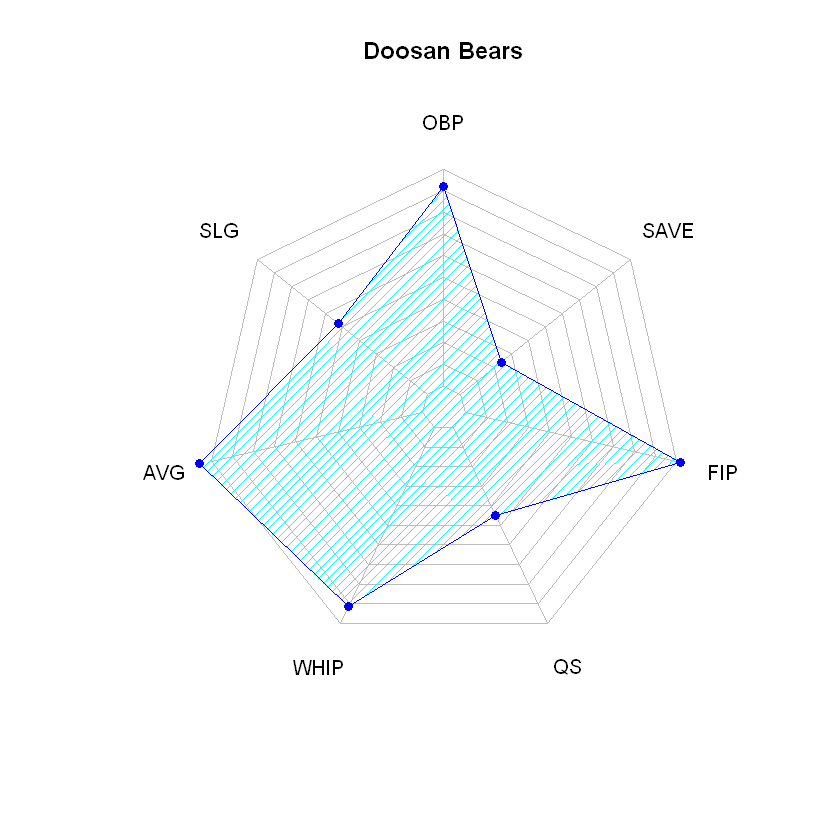

In [51]:
radarchart(ds, title='Doosan Bears',
           seg=10, pdensity=20, pcol=788, pfcol=5, plwd=1, plty=1,
           cglwd=1, cglcol=8, cglty=1, axistype=0,
           vlabels=c("OBP", "SLG", "AVG", "WHIP", "QS", "FIP", "SAVE"), maxmin=TRUE)

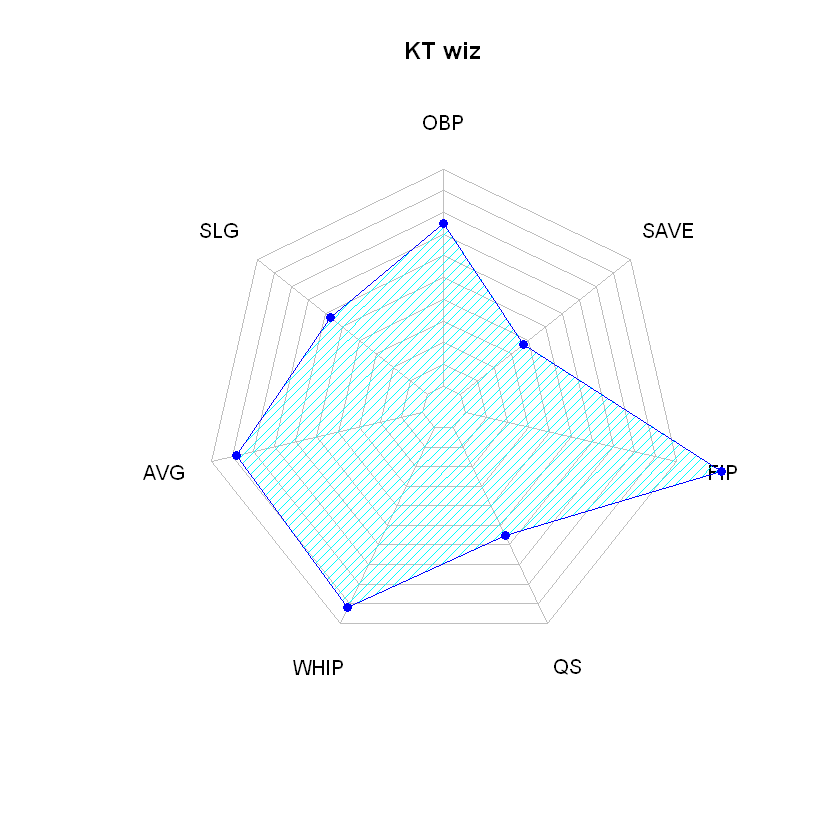

In [55]:

radarchart(kt, title='KT wiz',
           seg=10, pdensity=20, pcol=788, pfcol=5, plwd=1, plty=1,
           cglwd=1, cglcol=8, cglty=1, axistype=0,
           vlabels=c("OBP", "SLG", "AVG", "WHIP", "QS", "FIP", "SAVE"), maxmin=TRUE)

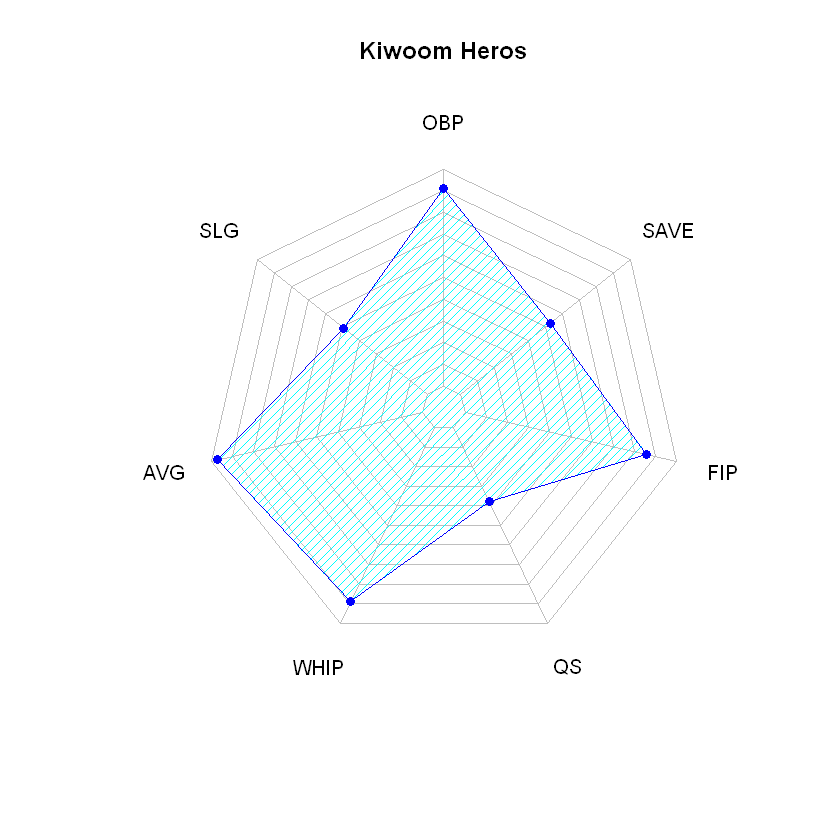

In [56]:
radarchart(nx, title='Kiwoom Heros',
           seg=10, pdensity=20, pcol=788, pfcol=5, plwd=1, plty=1,
           cglwd=1, cglcol=8, cglty=1, axistype=0,
           vlabels=c("OBP", "SLG", "AVG", "WHIP", "QS", "FIP", "SAVE"), maxmin=TRUE)

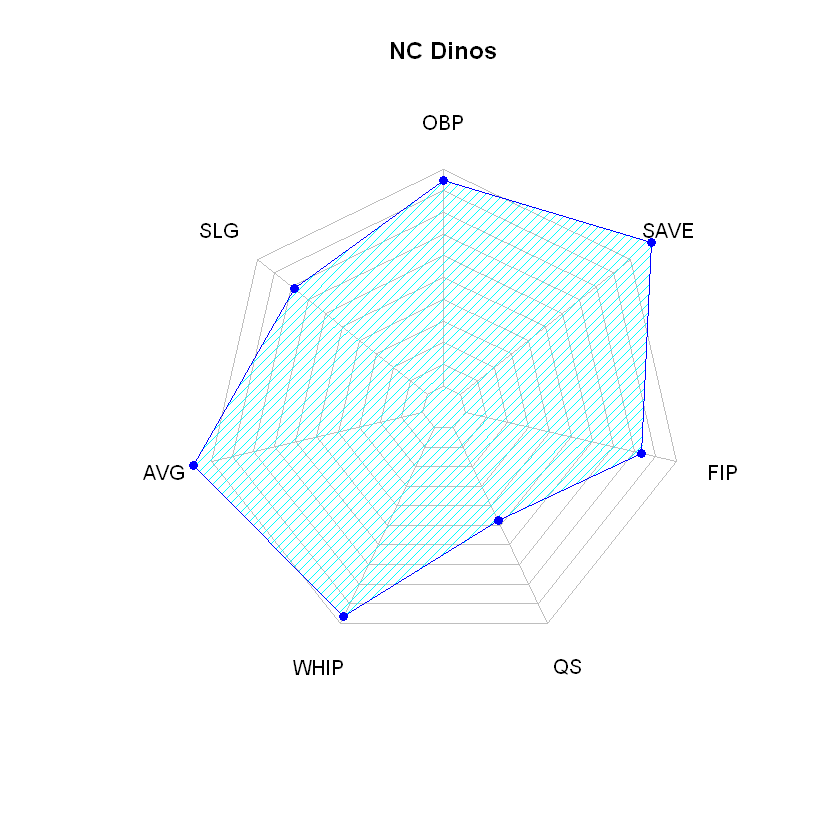

In [57]:

radarchart(nc, title='NC Dinos',
           seg=10, pdensity=20, pcol=788, pfcol=5, plwd=1, plty=1,
           cglwd=1, cglcol=8, cglty=1, axistype=0,
           vlabels=c("OBP", "SLG", "AVG", "WHIP", "QS", "FIP", "SAVE"), maxmin=TRUE)

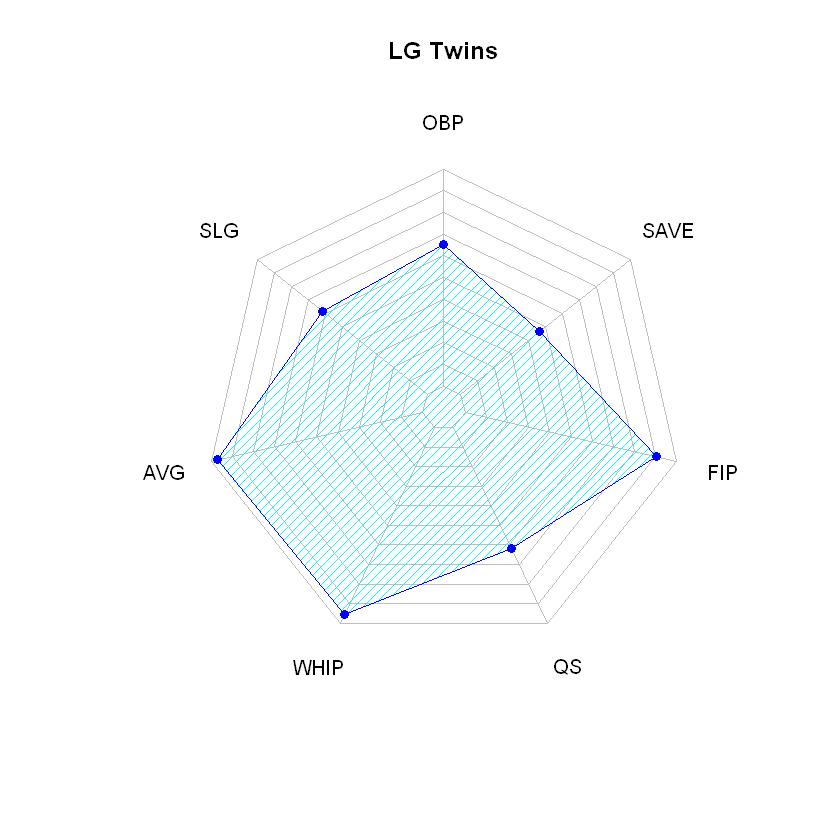

In [58]:
radarchart(lg, title='LG Twins',
           seg=10, pdensity=20, pcol=788, pfcol=5, plwd=1, plty=1,
           cglwd=1, cglcol=8, cglty=1, axistype=0,
           vlabels=c("OBP", "SLG", "AVG", "WHIP", "QS", "FIP", "SAVE"), maxmin=TRUE)

In [61]:
ds.nc = data.frame(
    'OBP'= c(0.60, 0),
    'SLG'= c(0.60, 0),
    'AVG'= c(0.60, 0),
    'WHIP'= c(0.60, 0),
    'QS'= c(0.60, 0),
    'FIP'= c(0.60, 0),
    'SAVE'=c(0.60, 0)
)
ds.nc = rbind(ds.nc, get_radarchart_row(all_team_norm[['ds']][['batters']], all_team_norm[['ds']][['pitchers']]))
ds.nc = rbind(ds.nc, get_radarchart_row(all_team_norm[['nc']][['batters']], all_team_norm[['nc']][['pitchers']]))

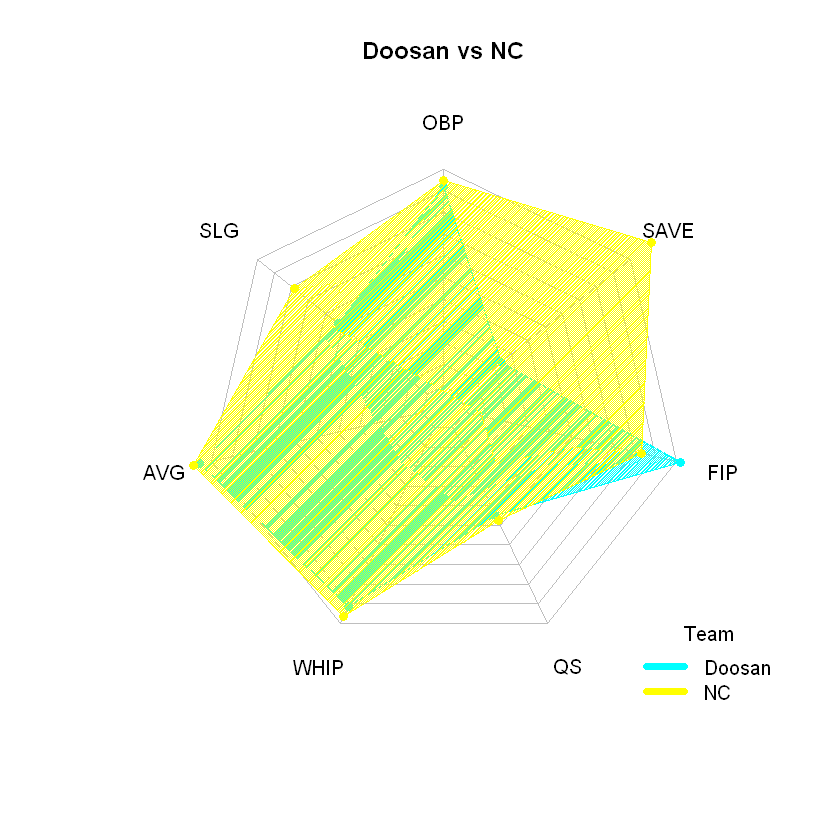

In [66]:
radarchart(ds.nc, title='Doosan vs NC',
           seg=10, pdensity=100, pcol=c(5,7,8,2), pfcol=c(5,7,8,2), plwd=0.125, plty=1, 
           cglwd=1, cglcol=8, cglty=1, axistype=0,
           vlabels=c("OBP", "SLG", "AVG", "WHIP", "QS", "FIP", "SAVE"), maxmin=TRUE)
legend('bottomright', legend=c('Doosan', 'NC'), title="Team", bty="n", lwd=6, col=c(5,7))

In [64]:
top4 = data.frame(
    'OBP'= c(0.60, 0),
    'SLG'= c(0.60, 0),
    'AVG'= c(0.60, 0),
    'WHIP'= c(0.60, 0),
    'QS'= c(0.60, 0),
    'FIP'= c(0.60, 0),
    'SAVE'=c(0.60, 0)
)

top4 = rbind(top4, get_radarchart_row(all_team_norm[['ds']][['batters']], all_team_norm[['ds']][['pitchers']]))
top4 = rbind(top4, get_radarchart_row(all_team_norm[['lg']][['batters']], all_team_norm[['lg']][['pitchers']]))
top4 = rbind(top4, get_radarchart_row(all_team_norm[['nc']][['batters']], all_team_norm[['nc']][['pitchers']]))
top4 = rbind(top4, get_radarchart_row(all_team_norm[['kt']][['batters']], all_team_norm[['kt']][['pitchers']]))

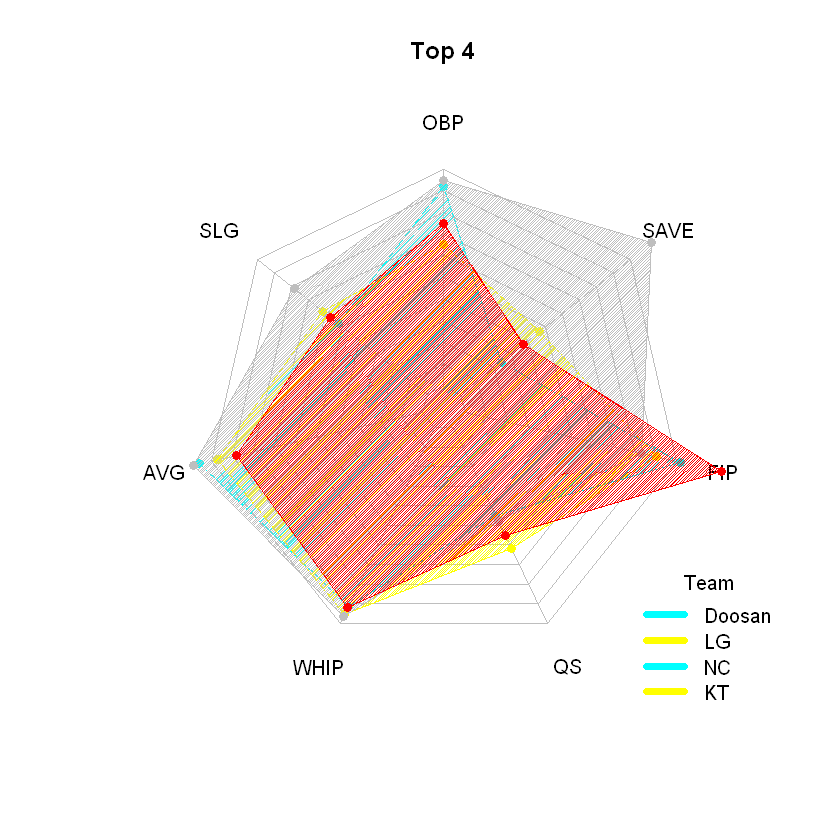

In [73]:
radarchart(top4, title='Top 4',
           seg=10, pdensity=70, pcol=c(5,7,8,2), pfcol=c(5,7,8,2), plwd=0.125, plty=1, 
           cglwd=1, cglcol=8, cglty=1, axistype=0,
           vlabels=c("OBP", "SLG", "AVG", "WHIP", "QS", "FIP", "SAVE"), maxmin=TRUE)
legend('bottomright', legend=c('Doosan', 'LG','NC','KT'), title="Team", bty="n", lwd=6, col=c(5,7))

In [ ]:
lg.nx = data.frame(
    'OBP'= c(0.60, 0),
    'SLG'= c(0.60, 0),
    'AVG'= c(0.60, 0),
    'WHIP'= c(0.60, 0),
    'QS'= c(0.60, 0),
    'FIP'= c(0.60, 0),
    'SAVE'=c(0.60, 0)
)
lg.nx = rbind(ds.nc, get_radarchart_row(all_team_norm[['ds']][['batters']], all_team_norm[['ds']][['pitchers']]))
ds.nc = rbind(ds.nc, get_radarchart_row(all_team_norm[['nc']][['batters']], all_team_norm[['nc']][['pitchers']]))